<a href="https://colab.research.google.com/github/David-dmh/DL-PBA3/blob/main/DL_PBA3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import io
import copy
import os
import time
import random
from random import randint
import shutil
import datetime
import re
import glob
import imageio
import PIL
import time
from IPython import display
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tqdm.notebook import tqdm 

import tensorflow as tf
from tensorflow import keras
from keras.datasets import mnist
from tensorflow.keras import layers
from keras.callbacks import EarlyStopping, TensorBoard
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential, Model
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import Adam, RMSprop
from keras.regularizers import l1
from keras.utils import np_utils
from keras.utils.np_utils import to_categorical

%load_ext tensorboard


# Convolutional Neural Networks

In [ ]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
download = drive.CreateFile({"id": "1HuImqzXa6gzpdr3v6tF_Nfgvj16rao2g"})
download.GetContentFile("x_train_planes.npy")
X_train_planes = np.load("x_train_planes.npy")

download = drive.CreateFile({"id": "10a_hx_irAKWFdcjgpu7_DhlLJBt129vs"})
download.GetContentFile("y_train_planes.npy")
y_train_planes = np.load("y_train_planes.npy")

download = drive.CreateFile({"id": "1zCM1BOs44Sp4wMHKE0idjTWHNnIyGX4R"})
download.GetContentFile("x_test_planes.npy")
X_test_planes = np.load("x_test_planes.npy")

download = drive.CreateFile({"id": "1fYXPKl8yEacuHVpHxVb4G7awyLMO2JUC"})
download.GetContentFile("y_test_planes.npy")
y_test_planes = np.load("y_test_planes.npy")

In [ ]:
print(X_train_planes.shape, y_train_planes.shape, X_test_planes.shape, y_test_planes.shape)

(25600, 20, 20, 3) (25600,) (6400, 20, 20, 3) (6400,)


1


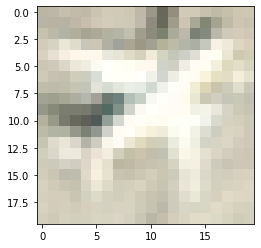

In [ ]:
def inspect_test_data(item=0):
  plt.imshow(X_train_planes[item]); 
  print(y_train_planes[item])

inspect_test_data(33)

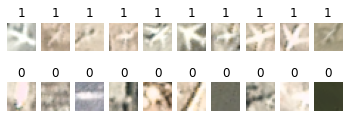

In [ ]:
def visualize_data(positive_images, negative_images):
    figure = plt.figure()
    count = 0
    for i in range(positive_images.shape[0]):
        count += 1
        figure.add_subplot(2, positive_images.shape[0], count)
        plt.imshow(positive_images[i, :, :])
        plt.axis("off")
        plt.title("1")
        figure.add_subplot(1, negative_images.shape[0], count)
        plt.imshow(negative_images[i, :, :])
        plt.axis("off")
        plt.title("0")

    plt.show()

N_TO_VISUALIZE = 10

positive_example_indices = (y_train_planes == 1)
positive_examples = X_train_planes[positive_example_indices, :, :]
positive_examples = positive_examples[0:N_TO_VISUALIZE, :, :]

negative_example_indices = (y_train_planes == 0)
negative_examples = X_train_planes[negative_example_indices, :, :]
negative_examples = negative_examples[0:N_TO_VISUALIZE, :, :]

visualize_data(positive_examples, negative_examples)

## i.

In [ ]:
cnn_model = keras.Sequential([layers.InputLayer(input_shape=(20, 20, 3)),
                              layers.Conv2D(32, (3, 3), activation="relu"),
                              layers.MaxPooling2D((2, 2)),
                              layers.Flatten(),
                              layers.Dense(32, activation="relu"), 
                              layers.Dense(1, activation="sigmoid")])
cnn_model.compile(optimizer="adam", 
                  loss="binary_crossentropy", 
                  metrics=["binary_accuracy"])
!rm -rf ./logs/
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, 
                                                      histogram_freq=1)
history_cnn = cnn_model.fit(X_train_planes, y_train_planes, 
                            validation_data=(X_test_planes, y_test_planes), 
                            batch_size=32, 
                            epochs=100,
                            callbacks=[tensorboard_callback])

Epoch 1/100
800/800 [==============================] - 10s 13ms/step - loss: 0.3168 - binary_accuracy: 0.8652 - val_loss: 0.2268 - val_binary_accuracy: 0.9102
Epoch 2/100
800/800 [==============================] - 10s 12ms/step - loss: 0.1693 - binary_accuracy: 0.9353 - val_loss: 0.1478 - val_binary_accuracy: 0.9448
Epoch 3/100
800/800 [==============================] - 9s 12ms/step - loss: 0.1387 - binary_accuracy: 0.9467 - val_loss: 0.1436 - val_binary_accuracy: 0.9459
Epoch 4/100
800/800 [==============================] - 10s 12ms/step - loss: 0.1304 - binary_accuracy: 0.9511 - val_loss: 0.1217 - val_binary_accuracy: 0.9531
Epoch 5/100
800/800 [==============================] - 10s 12ms/step - loss: 0.1172 - binary_accuracy: 0.9554 - val_loss: 0.1463 - val_binary_accuracy: 0.9430
Epoch 6/100
800/800 [==============================] - 10s 13ms/step - loss: 0.1109 - binary_accuracy: 0.9583 - val_loss: 0.1130 - val_binary_accuracy: 0.9561
Epoch 7/100
800/800 [==========================

In [ ]:
y_pred

array([[2.5169268e-11],
       [2.1486982e-11],
       [1.0000000e+00],
       ...,
       [2.9474485e-12],
       [7.8835044e-17],
       [9.6548045e-01]], dtype=float32)

In [ ]:
y_pred = np.round(cnn_model.predict(X_test_planes))
accuracy = accuracy_score(y_test_planes, y_pred)
precision = precision_score(y_test_planes, y_pred)
recall = recall_score(y_test_planes, y_pred)
f1 = f1_score(y_test_planes, y_pred)

accuracy, precision, recall, f1

(0.97625, 0.9393939393939394, 0.9693439607602697, 0.9541339770669884)

In [ ]:
# %tensorboard --logdir logs/fit

## ii.
Possible improvements:
- Early stopping
- Regularisation
- Increase network capacity - addtional convolutional and max pooling layer.

Early stopping:

In [ ]:
cnn_model_2 = keras.Sequential([layers.InputLayer(input_shape=(20, 20, 3)),
                                layers.Conv2D(32, (3, 3), activation="relu"),
                                layers.MaxPooling2D((2, 2)),
                                layers.Flatten(),
                                layers.Dense(32, activation="relu"), 
                                layers.Dense(1, activation="sigmoid")])
cnn_model_2.compile(optimizer="adam", 
                    loss="binary_crossentropy", 
                    metrics=["binary_accuracy"])
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, 
                                                      histogram_freq=1)
early_stopping = EarlyStopping(min_delta=0.001, 
                               patience=15, 
                               restore_best_weights=True)
history_cnn_2 = cnn_model_2.fit(X_train_planes, y_train_planes, 
                                validation_data=(X_test_planes, y_test_planes), 
                                batch_size=32, 
                                epochs=100,
                                callbacks=[tensorboard_callback, early_stopping])

Epoch 1/100
800/800 [==============================] - 10s 12ms/step - loss: 0.2969 - binary_accuracy: 0.8716 - val_loss: 0.1932 - val_binary_accuracy: 0.9228
Epoch 2/100
800/800 [==============================] - 10s 12ms/step - loss: 0.1614 - binary_accuracy: 0.9379 - val_loss: 0.1440 - val_binary_accuracy: 0.9448
Epoch 3/100
800/800 [==============================] - 9s 11ms/step - loss: 0.1361 - binary_accuracy: 0.9466 - val_loss: 0.1305 - val_binary_accuracy: 0.9528
Epoch 4/100
800/800 [==============================] - 9s 11ms/step - loss: 0.1213 - binary_accuracy: 0.9555 - val_loss: 0.1426 - val_binary_accuracy: 0.9417
Epoch 5/100
800/800 [==============================] - 9s 12ms/step - loss: 0.1088 - binary_accuracy: 0.9591 - val_loss: 0.1409 - val_binary_accuracy: 0.9416
Epoch 6/100
800/800 [==============================] - 10s 12ms/step - loss: 0.1021 - binary_accuracy: 0.9620 - val_loss: 0.1322 - val_binary_accuracy: 0.9481
Epoch 7/100
800/800 [============================

In [ ]:
y_pred =  np.round(cnn_model_2.predict(X_test_planes))
accuracy = accuracy_score(y_test_planes, y_pred)
precision = precision_score(y_test_planes, y_pred)
recall = recall_score(y_test_planes, y_pred)
f1 = f1_score(y_test_planes, y_pred)

accuracy, precision, recall, f1

(0.97921875, 0.9646401985111662, 0.9534028203556101, 0.9589885908109774)

Regularisation:

In [ ]:
cnn_model_3 = keras.Sequential([layers.InputLayer(input_shape=(20, 20, 3)),
                                layers.Conv2D(32, (3, 3), activation="relu"),
                                layers.MaxPooling2D((2, 2)),
                                layers.Flatten(),
                                layers.Dense(32, 
                                             activity_regularizer=l1(10e-5), 
                                             activation="relu"), 
                                layers.Dense(1, activation="sigmoid")])
cnn_model_3.compile(optimizer="adam", 
                    loss="binary_crossentropy", 
                    metrics=["binary_accuracy"])
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, 
                                                      histogram_freq=1)
history_cnn_3 = cnn_model_3.fit(X_train_planes, y_train_planes, 
                                validation_data=(X_test_planes, y_test_planes), 
                                batch_size=32, 
                                epochs=100,
                                callbacks=[tensorboard_callback, early_stopping])

Epoch 1/100
800/800 [==============================] - 9s 11ms/step - loss: 0.3151 - binary_accuracy: 0.8662 - val_loss: 0.1832 - val_binary_accuracy: 0.9312
Epoch 2/100
800/800 [==============================] - 9s 11ms/step - loss: 0.1666 - binary_accuracy: 0.9362 - val_loss: 0.2076 - val_binary_accuracy: 0.9145
Epoch 3/100
800/800 [==============================] - 8s 11ms/step - loss: 0.1469 - binary_accuracy: 0.9450 - val_loss: 0.1336 - val_binary_accuracy: 0.9502
Epoch 4/100
800/800 [==============================] - 8s 10ms/step - loss: 0.1318 - binary_accuracy: 0.9498 - val_loss: 0.1234 - val_binary_accuracy: 0.9541
Epoch 5/100
800/800 [==============================] - 9s 11ms/step - loss: 0.1224 - binary_accuracy: 0.9550 - val_loss: 0.1168 - val_binary_accuracy: 0.9544
Epoch 6/100
800/800 [==============================] - 8s 11ms/step - loss: 0.1120 - binary_accuracy: 0.9590 - val_loss: 0.1316 - val_binary_accuracy: 0.9502
Epoch 7/100
800/800 [==============================]

In [ ]:
y_pred = np.round(cnn_model_3.predict(X_test_planes))
accuracy = accuracy_score(y_test_planes, y_pred)
precision = precision_score(y_test_planes, y_pred)
recall = recall_score(y_test_planes, y_pred)
f1 = f1_score(y_test_planes, y_pred)

accuracy, precision, recall, f1

(0.979375, 0.9545178896300789, 0.9650521152667075, 0.9597560975609757)

Increase capacity:

In [ ]:
cnn_model_4 = keras.Sequential([layers.InputLayer(input_shape=(20, 20, 3)),
                                layers.Conv2D(32, (3, 3), activation="relu"),
                                layers.MaxPooling2D((2, 2)),
                                layers.Conv2D(32, (3, 3), activation="relu"),
                                layers.MaxPooling2D((2, 2)),
                                layers.Flatten(),
                                layers.Dense(32, activation="relu"), 
                                layers.Dense(32, activation="relu"), 
                                layers.Dense(1, activation="sigmoid")])
cnn_model_4.compile(optimizer="adam", 
                    loss="binary_crossentropy", 
                    metrics=["binary_accuracy"])
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, 
                                                      histogram_freq=1)
history_cnn_4 = cnn_model_4.fit(X_train_planes, y_train_planes, 
                                validation_data=(X_test_planes, y_test_planes), 
                                batch_size=32, 
                                epochs=100,
                                callbacks=[tensorboard_callback, early_stopping])

Epoch 1/100
800/800 [==============================] - 13s 16ms/step - loss: 0.3612 - binary_accuracy: 0.8339 - val_loss: 0.2058 - val_binary_accuracy: 0.9183
Epoch 2/100
800/800 [==============================] - 12s 15ms/step - loss: 0.1769 - binary_accuracy: 0.9300 - val_loss: 0.1805 - val_binary_accuracy: 0.9237
Epoch 3/100
800/800 [==============================] - 13s 16ms/step - loss: 0.1364 - binary_accuracy: 0.9455 - val_loss: 0.1361 - val_binary_accuracy: 0.9461
Epoch 4/100
800/800 [==============================] - 13s 16ms/step - loss: 0.1139 - binary_accuracy: 0.9555 - val_loss: 0.1085 - val_binary_accuracy: 0.9591
Epoch 5/100
800/800 [==============================] - 13s 16ms/step - loss: 0.1031 - binary_accuracy: 0.9612 - val_loss: 0.1148 - val_binary_accuracy: 0.9556
Epoch 6/100
800/800 [==============================] - 12s 15ms/step - loss: 0.0940 - binary_accuracy: 0.9645 - val_loss: 0.0933 - val_binary_accuracy: 0.9673
Epoch 7/100
800/800 [=========================

In [ ]:
y_pred = np.round(cnn_model_4.predict(X_test_planes))
accuracy = accuracy_score(y_test_planes, y_pred)
precision = precision_score(y_test_planes, y_pred)
recall = recall_score(y_test_planes, y_pred)
f1 = f1_score(y_test_planes, y_pred)

accuracy, precision, recall, f1

(0.975, 0.9444108761329305, 0.9583077866339669, 0.9513085818624466)

## iii.
**Classification report**:  
Chosen model was *cnn_model_3*. It has early stopping, regularisation and has the following architecture:  

In [ ]:
cnn_model_3.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 18, 18, 32)        896       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 9, 9, 32)          0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 2592)              0         
_________________________________________________________________
dense_10 (Dense)             (None, 32)                82976     
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 33        
Total params: 83,905
Trainable params: 83,905
Non-trainable params: 0
_________________________________________________________________


Key metrics:
- Accuracy = 97.9375 %
- F1 = 95.9756 %  

Other metrics:  
- Precision = 95.4518 %
- Recall = 96.5052 %


# Long Short-Term Networks

## i.

In [ ]:
download = drive.CreateFile({"id": "1q4UpfYwF6uR5OTSd5Eyfeh5c48Q3ITvL"})
download.GetContentFile("complaints.csv")
complaints = pd.read_csv("complaints.csv")
print(complaints.shape)
complaints.head(3)

(38909, 4)


,Unnamed: 0,product,consumer_complaint_narrative,category_id
0,190126,Debt collection,XXXX has claimed I owe them {$27.00} for XXXX ...,0
1,190135,Consumer Loan,Due to inconsistencies in the amount owed that...,1
2,190155,Mortgage,In XX/XX/XXXX my wages that I earned at my job...,2


In [ ]:
complaints.drop(["Unnamed: 0", "product"], axis=1, inplace=True)
complaints.head()

,consumer_complaint_narrative,category_id
0,XXXX has claimed I owe them {$27.00} for XXXX ...,0
1,Due to inconsistencies in the amount owed that...,1
2,In XX/XX/XXXX my wages that I earned at my job...,2
3,I have an open and current mortgage with Chase...,2
4,XXXX was submitted XX/XX/XXXX. At the time I s...,2


In [ ]:
complaints.shape

(38909, 2)

## ii.

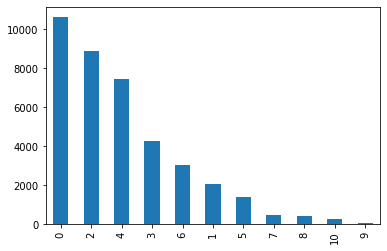

In [ ]:
complaints["category_id"].value_counts().sort_values(ascending=False).plot(kind="bar");

Text preprocessing:

In [ ]:
complaints.iloc[:, 0]

0        XXXX has claimed I owe them {$27.00} for XXXX ...
1        Due to inconsistencies in the amount owed that...
2        In XX/XX/XXXX my wages that I earned at my job...
3        I have an open and current mortgage with Chase...
4        XXXX was submitted XX/XX/XXXX. At the time I s...
                               ...                        
38904    I was contacted by Amsher Collection Agency vi...
38905    I ordered products from XXXX XXXX XXXX and pai...
38906    I am filing this complaint because EXPERIAN ha...
38907    They call more than 5 times a day. They never ...
38908    Loan # XXXX XXXX XXXXProperty Address : XXXX X...
Name: consumer_complaint_narrative, Length: 38909, dtype: object

In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
complaints = complaints.reset_index(drop=True)
REPLACE_BY_SPACE_RE = re.compile("[/(){}\[\]\|@,;]")
BAD_SYMBOLS_RE = re.compile("[^0-9a-z #+_]")
STOPWORDS = set(stopwords.words("english"))

def clean_text(text):
    """
    text: a string
    Returns: modified initial string
    """
    text = text.lower()
    text = REPLACE_BY_SPACE_RE.sub(' ', text)
    text = BAD_SYMBOLS_RE.sub('', text)
    text = text.replace('x', '')
    text = ' '.join(word for word in text.split() if word not in STOPWORDS)

    return text

complaints["consumer_complaint_narrative"] = complaints["consumer_complaint_narrative"].apply(clean_text)
complaints["consumer_complaint_narrative"] = complaints["consumer_complaint_narrative"].str.replace('\d+', '')

In [ ]:
complaints.iloc[:, 0][0]

'claimed owe  years despite proof payment sent canceled check ownpaid invoice  continue insist owe collection agencies stop harassment bill already paid four years ago'

In [ ]:
complaints.head()

,consumer_complaint_narrative,category_id
0,claimed owe years despite proof payment sent ...,0
1,due inconsistencies amount owed told bank amou...,1
2,wages earned job decreased almost half knew tr...,2
3,open current mortgage chase bank # chase repor...,2
4,submitted time submitted complaint dealt rushm...,2


In [ ]:
# more text processing tasks:
# vectorize by turning each text into seq of integers / vector
# limit data set to the top 50 000 words
# set max number of words in each complaint at 250

MAX_NB_WORDS = 50000
MAX_SEQUENCE_LENGTH = 250
EMBEDDING_DIM = 100
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, 
                      filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', 
                      lower=True)
tokenizer.fit_on_texts(complaints["consumer_complaint_narrative"].values)
word_index = tokenizer.word_index
print("Found %s unique tokens." % len(word_index))

Found 43423 unique tokens.


## iii.

In [ ]:
X = tokenizer.texts_to_sequences(complaints["consumer_complaint_narrative"].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print(X.shape)
X

(38909, 250)


array([[   0,    0,    0, ..., 1281,   39,  186],
       [   0,    0,    0, ..., 2137,  174,  199],
       [1130,  365, 4310, ...,  527, 3268, 1827],
       ...,
       [   0,    0,    0, ...,  576,  494,  310],
       [   0,    0,    0, ...,  151,  139,  245],
       [   0,    0,    0, ...,   11,   61,  230]], dtype=int32)

In [ ]:
y = pd.get_dummies(complaints["category_id"]).values
print(y.shape)
y

(38909, 11)


array([[1, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0]], dtype=uint8)

In [ ]:
train_ratio = .8
validation_ratio = .1
test_ratio = .1

X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size=1 - train_ratio,
    random_state=1
    )
X_val, X_test, y_val, y_test = train_test_split(
    X_test, 
    y_test, 
    test_size=test_ratio/(test_ratio + validation_ratio),
    random_state=1
    ) 
print(X.shape[0])
print(X_train.shape[0] + X_test.shape[0] + X_val.shape[0])
X_train.shape, y_train.shape, X_test.shape, y_test.shape, X_val.shape, y_val.shape

38909
38909


((31127, 250), (31127, 11), (3891, 250), (3891, 11), (3891, 250), (3891, 11))

## iv.

In [ ]:
rnn_mod = keras.Sequential([layers.Embedding(MAX_NB_WORDS, 
                                              EMBEDDING_DIM, 
                                              input_length=X_train.shape[1]), 
                             layers.SimpleRNN(128),
                             layers.Dense(11, 
                                          activation="softmax")])
rnn_mod.compile(optimizer="adam", 
                loss="categorical_crossentropy", 
                metrics=["accuracy"])
early_stopping = EarlyStopping(min_delta=0.001, 
                               patience=15, 
                               restore_best_weights=True)
rnn_history = rnn_mod.fit(X_train, y_train, 
                          validation_data=(X_val, y_val),
                          batch_size=32, 
                          epochs=5, 
                          callbacks=[early_stopping])

Epoch 1/5
973/973 [==============================] - 142s 145ms/step - loss: 1.8101 - accuracy: 0.3744 - val_loss: 1.4403 - val_accuracy: 0.5330
Epoch 2/5
973/973 [==============================] - 140s 144ms/step - loss: 1.5823 - accuracy: 0.4665 - val_loss: 1.4773 - val_accuracy: 0.5048
Epoch 3/5
973/973 [==============================] - 141s 144ms/step - loss: 1.4186 - accuracy: 0.5501 - val_loss: 1.2631 - val_accuracy: 0.6032
Epoch 4/5
973/973 [==============================] - 139s 143ms/step - loss: 1.4253 - accuracy: 0.5286 - val_loss: 1.6089 - val_accuracy: 0.4582
Epoch 5/5
973/973 [==============================] - 139s 142ms/step - loss: 1.2764 - accuracy: 0.5802 - val_loss: 1.3327 - val_accuracy: 0.5644


In [ ]:
print(np.mean(rnn_history.history["val_accuracy"])*100)
rnn_mod.evaluate(X_test, y_test)

53.27165186405182
122/122 [==============================] - 3s 24ms/step - loss: 1.3161 - accuracy: 0.5652


[1.3160613775253296, 0.5651503205299377]

## v.

In [ ]:
lstm_mod = keras.Sequential([layers.Embedding(MAX_NB_WORDS, 
                                              EMBEDDING_DIM, 
                                              input_length=X_train.shape[1]), 
                             layers.SpatialDropout1D(0.2),
                             layers.LSTM(100, 
                                         dropout=0.2, 
                                         recurrent_dropout=0.2),
                             layers.Dense(11, 
                                          activation="softmax")])
lstm_mod.compile(optimizer="adam", 
                 loss="categorical_crossentropy", 
                 metrics=["accuracy"])
lstm_history = lstm_mod.fit(X_train, y_train, 
                            validation_data=(X_val, y_val),
                            batch_size=32, 
                            epochs=5, 
                            callbacks=[early_stopping])

Epoch 1/5
973/973 [==============================] - 585s 599ms/step - loss: 1.2506 - accuracy: 0.5959 - val_loss: 0.8997 - val_accuracy: 0.7294
Epoch 2/5
973/973 [==============================] - 585s 601ms/step - loss: 0.8691 - accuracy: 0.7390 - val_loss: 0.8027 - val_accuracy: 0.7564
Epoch 3/5
973/973 [==============================] - 584s 601ms/step - loss: 0.6421 - accuracy: 0.8067 - val_loss: 0.6925 - val_accuracy: 0.7923
Epoch 4/5
973/973 [==============================] - 584s 600ms/step - loss: 0.5722 - accuracy: 0.8292 - val_loss: 0.6739 - val_accuracy: 0.8070
Epoch 5/5
973/973 [==============================] - 582s 599ms/step - loss: 0.4841 - accuracy: 0.8578 - val_loss: 0.6497 - val_accuracy: 0.8108


In [ ]:
print(np.mean(lstm_history.history["val_accuracy"])*100)
lstm_mod.evaluate(X_test, y_test)

77.91827321052551
122/122 [==============================] - 8s 65ms/step - loss: 0.6110 - accuracy: 0.8219


[0.611047089099884, 0.8218966722488403]

## vi.
On both the validation and test sets, the LSTM model outperformed the RNN in terms of accuracy. LSTMs are usually more suited to these problems and this is exaggerated in this problem containing multiple classes to predict. The reason LSTMs are better is likely since they are better at remembering long (short) term dependencies. 

# A3C and GAN

## 2. i.

In [ ]:
# !pip install imageio
# !pip install git+https://github.com/tensorflow/docs

  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-bgu8_622
  Running command git clone -q https://github.com/tensorflow/docs /tmp/pip-req-build-bgu8_622
  Created wheel for tensorflow-docs: filename=tensorflow_docs-0.0.0fef367d8447ce4f5fe648bc6e8b07baf5359bacc_-py3-none-any.whl size=154289 sha256=32e78809980fbdd6640b2a3ec526fa6a26af251bd6da8e806272b92f3f738dab
  Stored in directory: /tmp/pip-ephem-wheel-cache-ehxec1_2/wheels/cc/c4/d8/5341e93b6376c5c929c49469fce21155eb69cef1a4da4ce32c
Failed to build tensorflow-docs
    Running setup.py install for tensorflow-docs ... done
  DEPRECATION: tensorflow-docs was installed using the legacy 'setup.py install' method, because a wheel could not be built for it. A possible replacement is to fix the wheel build issue reported above. You can find discussion regarding this at https://github.com/pypa/pip/issues/8368.


In [ ]:
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()

11493376/11490434 [==============================] - 32s 3us/step


## ii.

In [ ]:
train_images = train_images.reshape(train_images.shape[0], 
                                    28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5  # normalize the images to [-1, 1]

In [ ]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256

In [ ]:
# batch and shuffle data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [ ]:
# define generator
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256)  # Note: None is the batch size
    model.add(layers.Conv2DTranspose(128, 
                                     (5, 5), 
                                     strides=(1, 1), 
                                     padding='same', 
                                     use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Conv2DTranspose(64, 
                                     (5, 5), 
                                     strides=(2, 2), 
                                     padding='same', 
                                     use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Conv2DTranspose(1, 
                                     (5, 5), 
                                     strides=(2, 2), 
                                     padding='same', 
                                     use_bias=False, 
                                     activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model

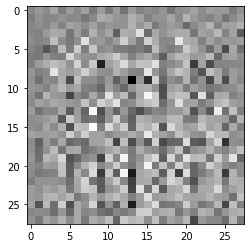

In [ ]:
# use untrained generator to create image
generator = make_generator_model()
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)
plt.imshow(generated_image[0, :, :, 0], cmap='gray');

In [ ]:
# define discriminator
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [ ]:
# classify generated image above as real/fake (using untrained discriminator)
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[-0.0009099]], shape=(1, 1), dtype=float32)


In [ ]:
# helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [ ]:
def discriminator_loss(real_output, fake_output):
    """
    Returns: total loss from real and fake output for discriminator
    """
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [ ]:
def generator_loss(fake_output):
    """
    Returns: cross entropy measure of fake output for generator
    """
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [ ]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [ ]:
# define training parameters
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16

# seed to reuse overtime to visualize progress in GIF
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [ ]:
@tf.function
def train_step(images):
    """
    Define a training step.
    """
    noise = tf.random.normal([BATCH_SIZE, noise_dim])
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [ ]:
def train(dataset, epochs):
    """
    Define training procedure.
    """
    for epoch in range(epochs):
        print(epoch)
        start = time.time()

    for image_batch in dataset:
        train_step(image_batch)

    # produce images for the GIF in training
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # save model every 15 epochs
    if (epoch + 1) % 15 == 0:
        checkpoint.save(file_prefix = checkpoint_prefix)

    print ("Time for epoch {} is {} sec".format(epoch + 1, 
                                                time.time()-start))

  # generate after final epoch
    display.clear_output(wait=True)
    generate_and_save_images(generator, epochs, seed)

In [ ]:
def generate_and_save_images(model, epoch, test_input):
    # `training` set to False so all layers use batchnorm
    predictions = model(test_input, training=False)
    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')

    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

## iii.

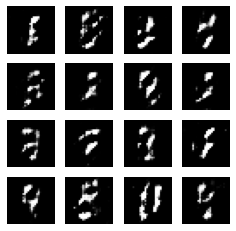

Time for epoch 8 is 1023.5622560977936 sec
8


In [ ]:
train(train_dataset, EPOCHS)

In [ ]:
# restore checkpoint to resume training
# checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [ ]:
def display_image(epoch_no):
    return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

display_image(EPOCHS) # show last epoch image